# predicting song popularity based on audio features using linear regression.
0.0364 accuracy seems to imply wrong application. 

Expected 0.2-0.4, based on:
- https://github.com/twillstw/Spotify-Popularity-Prediction/blob/master/Predicting_Song_Popularity.ipynb
- https://www.tandfonline.com/doi/epdf/10.1080/23270012.2023.2239824?needAccess=true

## Setup

In [126]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from datetime import date

%matplotlib inline
sns.set() # Setting seaborn as default style even if use only matplotlib

In [70]:
# constants
dataset_filename = 'Spotify_Dataset_V3_local.csv'
audio_features_col_names = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence']

In [71]:
spotify_filepath = os.path.join(os.getcwd(),'data', dataset_filename)
print(spotify_filepath)

spotify_data = pd.read_csv(spotify_filepath, delimiter=";")
spotify_data

/Users/neo/Documents/1-app-ml/aml-code/AML-spotify/data/Spotify_Dataset_V3_local.csv


,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
2,2,WHERE SHE GOES,Bad Bunny,29/05/2023,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 1,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651931,197,Oh Lord,MiC LOWRY,01/01/2017,0.273,0.794,-6644.0,0.068,0.022,0.000,0.377,Artist 1,MiC LOWRY,Nationality 1,United Kingdom,Europe,4,4.0,1sTUEdVO85YU8Ymk2jeAls,https://open.spotify.com/track/1sTUEdVO85YU8Ym...
651932,198,Superstition - Single Version,Stevie Wonder,01/01/2017,0.650,0.658,-10908.0,0.085,0.089,0.004,0.883,Artist 1,Stevie Wonder,Nationality 1,United States,Anglo-America,3,3.0,5lXcSvHRVjQJ3LB2rLKQog,https://open.spotify.com/track/5lXcSvHRVjQJ3LB...
651933,199,Secrets,The Weeknd,01/01/2017,0.665,0.771,-5779.0,0.053,0.016,0.000,0.764,Artist 1,The Weeknd,Nationality 1,Canada,Anglo-America,2,2.0,3DX4Y0egvc0slLcLl31h2p,https://open.spotify.com/track/3DX4Y0egvc0slLc...
651934,200,Ni**as In Paris,"JAY-Z, Kanye West",01/01/2017,0.757,0.882,-6125.0,0.248,0.076,0.000,0.684,Artist 1,JAY-Z,Nationality 1,United States,Anglo-America,1,1.0,2KpCpk6HjXXLb7nnXoXA5O,https://open.spotify.com/track/2KpCpk6HjXXLb7n...


## data cleaning:
- Assume that 'Song URL' column is not needed
- all values are non-null, no need to remove rows
- should change "Date" column type to datetime
- sort dates via chronological order
- could rename columns (standard variable names)
- Scale the audio features
    - All features [0, 1]
    - Loudness : Log base 10 (of the absolute value) then divde by 60.

*TODO:*
- ~~verify all years full except 2023?~~
    --> total, use 2023

- **for different values (in the audio features) for the same song id:**
    - average

In [72]:
spotify_data.columns

Index(['Rank', 'Title', 'Artists', 'Date', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', '# of Artist', 'Artist (Ind.)', '# of Nationality',
       'Nationality', 'Continent', 'Points (Total)',
       'Points (Ind for each Artist/Nat)', 'id', 'Song URL'],
      dtype='object')

In [73]:
# Assume that 'Song URL' column is not needed
spotify_data.drop(['Song URL'], axis=1, inplace=True, errors='ignore')

# Rename columns
spotify_data = spotify_data.rename(columns={
    "# of Artist": "Num_of_artist", "Artist (Ind.)": "Artist_ind", "# of Nationality": "Num_of_nationality", 
    "Points (Total)": "Points_total", "Points (Ind for each Artist/Nat)": "Points_ind", "Song URL": "Song_URL"
})

In [74]:
# make "Date" column datetime type
spotify_data["Date"] = pd.to_datetime(spotify_data["Date"], dayfirst=True)
spotify_data.info()
# spotify_data.loc[0]["Date"]

# reverse dates
spotify_data = spotify_data.sort_values(by="Date")
# spotify_data.head()

# Keep in mind, ranks are also reversed now...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651936 entries, 0 to 651935
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Rank                651936 non-null  int64         
 1   Title               651936 non-null  object        
 2   Artists             651936 non-null  object        
 3   Date                651936 non-null  datetime64[ns]
 4   Danceability        651936 non-null  float64       
 5   Energy              651936 non-null  float64       
 6   Loudness            651936 non-null  float64       
 7   Speechiness         651936 non-null  float64       
 8   Acousticness        651936 non-null  float64       
 9   Instrumentalness    651936 non-null  float64       
 10  Valence             651936 non-null  float64       
 11  Num_of_artist       651936 non-null  object        
 12  Artist_ind          651936 non-null  object        
 13  Num_of_nationality  651936 no

In [75]:
# Scale the audio features.
spotify_data['Loudness'] = spotify_data['Loudness'].apply(lambda x: np.log10(np.abs(x)) / 60)
spotify_data.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Num_of_artist,Artist_ind,Num_of_nationality,Nationality,Continent,Points_total,Points_ind,id
651935,200,Ni**as In Paris,"JAY-Z, Kanye West",2017-01-01,0.757,0.882,0.063118,0.248,0.076,0.0,0.684,Artist 2,Kanye West,Nationality 2,United States,Anglo-America,1,1.0,2KpCpk6HjXXLb7nnXoXA5O
651770,62,Sexual,"NEIKED, Dyo",2017-01-01,0.803,0.569,0.064479,0.074,0.062,0.0,0.809,Artist 1,NEIKED,Nationality 1,Sweden,Europe,139,70.0,3AsAuGTaDQzavZZThyYlop
651769,61,"How Far I'll Go - From ""Moa""",Alessia Cara,2017-01-01,0.314,0.555,0.066372,0.370,0.157,0.0,0.159,Artist 1,Alessia Cara,Nationality 1,Canada,Anglo-America,140,140.0,5hYTyyh2odQKphUbMqc5gN
651768,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,0.064873,0.117,0.057,0.0,0.392,Artist 2,Rihanna,Nationality 2,Barbados,Anglo-America,141,70.0,11KJSRSgaDxqydKYiD2Jew
651767,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,0.064873,0.117,0.057,0.0,0.392,Artist 1,Drake,Nationality 1,Canada,Anglo-America,141,70.0,11KJSRSgaDxqydKYiD2Jew


## Preprocessing

In [76]:
# want one row per song.
dropped_artist_split = spotify_data.drop_duplicates(subset=['Title', 'Artists', 'Date'], keep="last") 
# TODO: should really keep the first listed artist.

grouped_by_title = dropped_artist_split.groupby(["Title", "Artists"])
grouped_by_title.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Num_of_artist,Artist_ind,Num_of_nationality,Nationality,Continent,Points_total,Points_ind,id
651769,61,"How Far I'll Go - From ""Moa""",Alessia Cara,2017-01-01,0.314,0.555,0.066372,0.370,0.157,0.0,0.159,Artist 1,Alessia Cara,Nationality 1,Canada,Anglo-America,140,140.0,5hYTyyh2odQKphUbMqc5gN
651767,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,0.064873,0.117,0.057,0.0,0.392,Artist 1,Drake,Nationality 1,Canada,Anglo-America,141,70.0,11KJSRSgaDxqydKYiD2Jew
651766,59,Panda,Desiigner,2017-01-01,0.576,0.766,0.061567,0.449,0.028,0.0,0.236,Artist 1,Desiigner,Nationality 1,United States,Anglo-America,142,142.0,5OOkp4U9P9oL23maHFHL1h
651764,58,Perfect Strangers,"Jos Blue, JP Cooper",2017-01-01,0.739,0.833,0.061667,0.046,0.350,0.0,0.699,Artist 1,Jos Blue,Nationality 1,United States,Anglo-America,143,72.0,5bZtRlMBU76vHuDOb1GM5u
651762,57,La Bicicleta,"Carlos Vives, Shakira",2017-01-01,0.736,0.964,0.055531,0.129,0.198,0.0,0.953,Artist 1,Carlos Vives,Nationality 1,Colombia,Latin-America,144,72.0,0sXvAOmXgjR2QUqLK1MltU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,85,Bye,Peso Pluma,2023-05-29,0.782,0.812,0.063673,0.047,0.567,0.0,0.700,Artist 1,Peso Pluma,Nationality 1,Mexico,Latin-America,116,116.0,6n2P81rPk2RTzwnNNgFOdb
57,37,Dance The Night (From Barbie The Album),Dua Lipa,2023-05-29,0.671,0.845,0.011547,0.048,0.021,0.0,0.775,Artist 1,Dua Lipa,Nationality 1,United Kingdom,Europe,164,164.0,1vYXt7VSjH9JIM5oRRo7vA
52,33,Hits Different,Taylor Swift,2023-05-29,0.672,0.782,0.063547,0.042,0.148,0.0,0.239,Artist 1,Taylor Swift,Nationality 1,United States,Anglo-America,168,168.0,3xYJScVfxByb61dYHTwiby
284,194,Car's Outside,James Arthur,2023-05-29,0.338,0.562,0.064270,0.029,0.039,0.0,0.259,Artist 1,James Arthur,Nationality 1,United Kingdom,Europe,7,7.0,0otRX6Z89qKkHkQ9OqJpKt


In [77]:
summed_points = grouped_by_title["Points_total"].sum()

In [78]:
grouped_by_title.get_group(("Queencard", "(G)I-DLE"))

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Num_of_artist,Artist_ind,Num_of_nationality,Nationality,Continent,Points_total,Points_ind,id
3991,132,Queencard,(G)I-DLE,2023-05-16,0.815,0.834,0.057525,0.048,0.033,0.0,0.692,Artist 1,(G)I-DLE,Nationality 1,South Korea,Asia,69,69.0,4uOBL4DDWWVx4RhYKlPbPC
3666,105,Queencard,(G)I-DLE,2023-05-17,0.815,0.834,0.057525,0.048,0.033,0.0,0.692,Artist 1,(G)I-DLE,Nationality 1,South Korea,Asia,96,96.0,4uOBL4DDWWVx4RhYKlPbPC
3390,112,Queencard,(G)I-DLE,2023-05-18,0.815,0.834,0.057525,0.048,0.033,0.0,0.692,Artist 1,(G)I-DLE,Nationality 1,South Korea,Asia,89,89.0,4uOBL4DDWWVx4RhYKlPbPC
3111,123,Queencard,(G)I-DLE,2023-05-19,0.815,0.834,0.057525,0.048,0.033,0.0,0.692,Artist 1,(G)I-DLE,Nationality 1,South Korea,Asia,78,78.0,4uOBL4DDWWVx4RhYKlPbPC
2844,143,Queencard,(G)I-DLE,2023-05-20,0.815,0.834,0.057525,0.048,0.033,0.0,0.692,Artist 1,(G)I-DLE,Nationality 1,South Korea,Asia,58,58.0,4uOBL4DDWWVx4RhYKlPbPC
2513,113,Queencard,(G)I-DLE,2023-05-21,0.815,0.834,0.057525,0.048,0.033,0.0,0.692,Artist 1,(G)I-DLE,Nationality 1,South Korea,Asia,88,88.0,4uOBL4DDWWVx4RhYKlPbPC
2215,105,Queencard,(G)I-DLE,2023-05-22,0.815,0.834,0.057525,0.048,0.033,0.0,0.692,Artist 1,(G)I-DLE,Nationality 1,South Korea,Asia,96,96.0,4uOBL4DDWWVx4RhYKlPbPC
1929,111,Queencard,(G)I-DLE,2023-05-23,0.815,0.834,0.057525,0.048,0.033,0.0,0.692,Artist 1,(G)I-DLE,Nationality 1,South Korea,Asia,90,90.0,4uOBL4DDWWVx4RhYKlPbPC
1644,113,Queencard,(G)I-DLE,2023-05-24,0.815,0.834,0.057525,0.048,0.033,0.0,0.692,Artist 1,(G)I-DLE,Nationality 1,South Korea,Asia,88,88.0,4uOBL4DDWWVx4RhYKlPbPC
1363,117,Queencard,(G)I-DLE,2023-05-25,0.815,0.834,0.057525,0.048,0.033,0.0,0.692,Artist 1,(G)I-DLE,Nationality 1,South Korea,Asia,84,84.0,4uOBL4DDWWVx4RhYKlPbPC


In [79]:
# add on the total points to the right
grouped_df = grouped_by_title.first()

In [96]:
one_row_one_song = grouped_df.merge(summed_points.rename("Points_sum"), left_index=True, right_index=True)
one_row_one_song.drop(['Num_of_nationality', "Nationality", "Continent", "Points_total", "Points_ind", "Num_of_artist", "Artist_ind"], axis=1, inplace=True, errors='ignore')
one_row_one_song

,,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,id,Points_sum
Title,Artists,,,,,,,,,,,
'98 Braves,Morgan Wallen,72,2023-03-03,0.488,0.670,0.062672,0.027,0.097,0.0,0.484,3oZ6dlSfCE9gZ55MGPJctc,287
!,Trippie Redd,56,2019-08-09,0.725,0.543,0.063335,0.084,0.030,0.0,0.693,5a1ofLoPiAn5xxf5UE6472,194
#PROUDCATOWNERREMIX,"XXXTENTACION, Rico Nasty",189,2019-08-23,0.783,0.522,0.063240,0.390,0.029,0.0,0.235,5dkZ2DrcPJrqwlRQe6Q35e,12
$$$,XXXTENTACION,67,2018-03-16,0.774,0.507,0.064035,0.065,0.064,0.0,0.508,65u1dHQyQyE4y4aN2eDmMF,1018
$€ Freestyle,Sfera Ebbasta,76,2020-11-20,0.813,0.670,0.065626,0.335,0.200,0.0,0.380,2j9wr1cxfYcMJoANfmoJA9,125
...,...,...,...,...,...,...,...,...,...,...,...,...
Î©. VIVRE UN PEU,Damso,166,2021-04-29,0.416,0.528,0.066914,0.291,0.178,0.0,0.203,5UNFWkGaEJgQFqoJxZWMzm,35
ÎŸ. OG,Damso,84,2021-04-29,0.576,0.446,0.066741,0.044,0.773,0.4,0.060,63ALxy05IGeKrfOjvGG7lO,117
İmdat,cakal,153,2022-04-18,0.786,0.748,0.064650,0.162,0.267,0.0,0.562,123hB20IVD2yw1NMIgrqb3,1161


In [ ]:
# add classes?

## Linear Regression

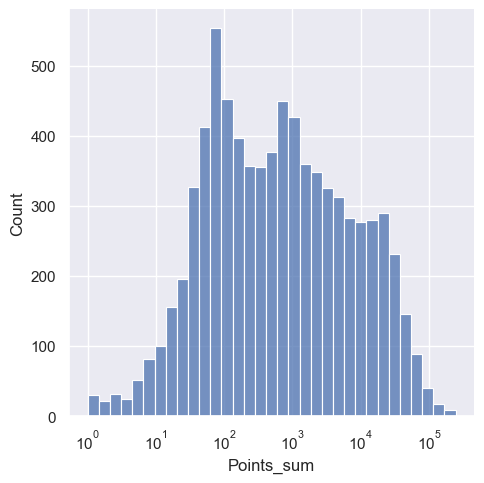

In [97]:
sns.displot(one_row_one_song, x=one_row_one_song["Points_sum"], log_scale=(True, False))

In [98]:
# one_row_one_song.sort_values(by="Points_sum")
one_row_one_song.describe()

,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Points_sum
count,7801.000000,7801,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000
mean,112.810281,2020-01-14 04:33:22.820151552,0.674761,0.635774,0.057985,0.131297,0.236030,0.014046,0.487988,6048.995257
min,1.000000,2017-01-01 00:00:00,0.073000,0.005000,-0.028316,0.022000,0.000000,0.000000,0.026000,1.000000
25%,58.000000,2018-06-29 00:00:00,0.582000,0.530000,0.060377,0.045000,0.041000,0.000000,0.312000,90.000000
50%,120.000000,2020-01-24 00:00:00,0.692000,0.652000,0.062669,0.078000,0.141000,0.000000,0.485000,588.000000
75%,172.000000,2021-07-23 00:00:00,0.785000,0.761000,0.064527,0.187000,0.355000,0.000000,0.662000,3994.000000
max,200.000000,2023-05-28 00:00:00,0.985000,0.996000,0.075625,0.966000,0.994000,0.956000,0.982000,244737.000000
std,62.625322,NaN,0.148632,0.172027,0.015326,0.120088,0.249934,0.083675,0.226476,15416.891904


In [118]:
correlations = one_row_one_song[['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence', 'Points_sum']].corr()

<Axes: >

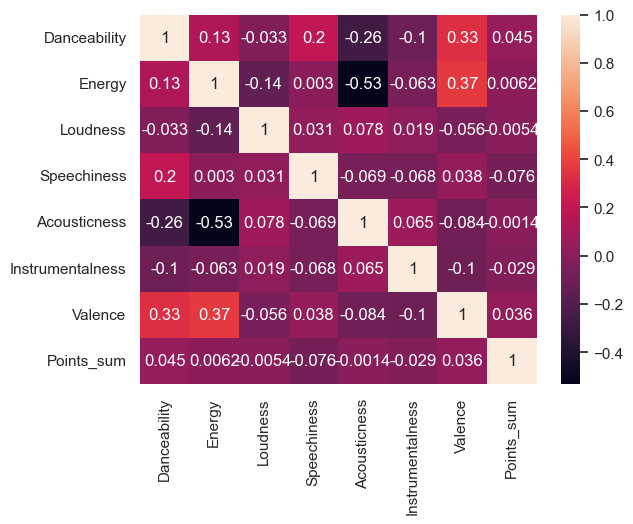

In [119]:
sns.heatmap(correlations, annot=True)

don't expect much, because features aren't highly correlated?

In [129]:
spotify_ordered = one_row_one_song.sort_values(by="Points_sum")

# Set random state
state=25

# Shuffle the data
reg_data = spotify_ordered.sample(frac=1, random_state=state).reset_index(drop=True)

# First, try without categoricals
X = reg_data.select_dtypes(include='number').drop('Points_sum', axis=1)
y = reg_data.Points_sum

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=state)

In [130]:
%%time

linreg = LinearRegression()
linreg.fit(X_train, y_train)

lin_pred = linreg.predict(X_test)

print(linreg.score(X_test, y_test))

0.03643102064324555
CPU times: user 19.1 ms, sys: 11.6 ms, total: 30.7 ms
Wall time: 27.3 ms
